In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import IPython.display as ipd

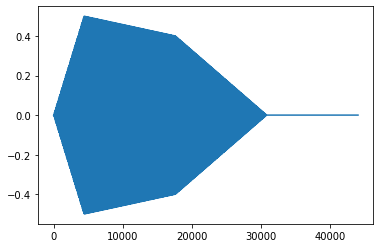

In [2]:
SAMPLE_RATE=44100
CLIP_DURATION=1
N_SAMPLES=SAMPLE_RATE*CLIP_DURATION
MAX_RECURSION=2

def plot(x):
    plt.figure(1)
    plt.plot(x)
    plt.show()


def play_audio(array,sample_rate):
  ipd.display(ipd.Audio(array,rate=sample_rate,autoplay=True))

def generate_envelope(a, d, s, r, n_samples, sample_rate):
  a_samp = math.floor(a*sample_rate)
  d_samp = math.floor(d*sample_rate)
  r_samp = math.floor(r*sample_rate)

  out = np.hstack([np.linspace(0, 1, a_samp), np.linspace(
      1, s, d_samp), np.linspace(s, 0, r_samp), np.zeros((n_samples-a_samp-d_samp-r_samp))])

  return out

class Operator:
  def __init__(self,base_freq,adsr,amp):
    self.modulators=[]
    self.base_freq=base_freq
    self.adsr=adsr
    self.amp=amp

  def generate(self,rl=0):
    if rl>MAX_RECURSION:
      return np.zeros((N_SAMPLES)) 
    freq=np.ones((N_SAMPLES))*self.base_freq
    modulated_freq=freq*0
    for m in self.modulators:
      modulated_freq=modulated_freq+freq*m.generate(rl+1)
    phase_in = np.cumsum((freq+modulated_freq)/SAMPLE_RATE)
    tone = np.sin(2*math.pi*phase_in)
    env=generate_envelope(self.adsr[0],self.adsr[1],self.adsr[2],self.adsr[3],N_SAMPLES,SAMPLE_RATE)
    return tone*env*self.amp
  
op1=Operator(440,[0.1,0.3,0.8,0.3],0.5)
op2=Operator(340,[0.3,0.3,0.5,0.3],0.5)
op3=Operator(840,[0,0.03,0.5,0.03],0.5)

op2.modulators=[op3]
op1.modulators=[op2]


w2=op1.generate()
plot(w2)

play_audio(w2,SAMPLE_RATE)

In [3]:
def dn_freq(x):
  return 20+2000*x
  
def dn_dur(x):
  return x*0.3

N_OPS=5
N_PARAMS=6

class SimpleFM:

  def get_op_params(self,):
    return [random.random() for i in range(6)]

  def denormalize_op_params(self,X):
    return [dn_freq(X[0]),dn_dur(X[1]),dn_dur(X[2]),X[3],dn_dur(X[4]),X[5]]

  def generate_params(self):
    folded_op_params=[self.get_op_params() for i in range(5)]
    return [item for sublist in folded_op_params for item in sublist]
    
  def denormalize_params(self,params):
    folded_op_params=[params[i*N_PARAMS:(i+1)*N_PARAMS] for i in range(N_OPS)]
    folded_dn_params=[self.denormalize_op_params(pr) for pr in folded_op_params]
    return folded_dn_params

  def generate(self,params):
    folded_dn_params=self.denormalize_params(params)
    ops=[Operator(pr[0],[pr[1],pr[2],pr[3],pr[4]],pr[5]) for pr in folded_dn_params]
    ops[0].modulators=[ops[1],ops[2]]
    ops[1].modulators=[ops[3],ops[4]]
    ops[2].modulators=[ops[2]]
    w2=ops[0].generate()
    return w2
    




   


In [4]:
fm=SimpleFM()

wp=fm.generate(fm.generate_params())

play_audio(wp,SAMPLE_RATE)


In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import time
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import re 
import os
from matplotlib import pyplot as plt

import scipy
import math
import numpy as np
import math
from scipy.io.wavfile import write
import matplotlib.pyplot as plt
import random
import IPython.display as ipd
import time


CLIP_DURATION=1
SAMPLE_RATE=44100
class DS(Dataset):
              
    def __getitem__(self, index):
        params=fm.generate_params()
        x = torch.as_tensor(fm.generate(params)).float()
        y = torch.as_tensor(params).float()
        return x, y

    def __len__(self):
        return 2048


trn_set=DS();
val_set=DS();
tst_set=DS();
def get_trn_loader(batch_size):
    trn_loader = torch.utils.data.DataLoader(trn_set, batch_size=batch_size, 
                                             drop_last=True )
    return(trn_loader)

def get_val_loader(batch_size):
  val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,  drop_last=True )
  return(val_loader)

def get_tst_loader(batch_size):
  tst_loader = torch.utils.data.DataLoader(tst_set, batch_size=batch_size, drop_last=True)
  return(tst_loader)


T=44100

In [6]:
DROPOUT=0.0
class SampleCNN(torch.torch.nn.Module):
    def __init__(self):
        super(SampleCNN, self).__init__()

        # 59049 x 1
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv1d(1, 128, kernel_size=3, stride=3, padding=0),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU())
        # 19683 x 128
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(3, stride=3))
        # 6561 x 128
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(3,stride=3))
        # 2187 x 128
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(3,stride=3))
        # 729 x 256
        self.conv5 = torch.nn.Sequential(
            torch.nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(3,stride=3))
        # 243 x 256
        self.conv6 = torch.nn.Sequential(
            torch.nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(3,stride=3),
            torch.nn.Dropout(DROPOUT))
        # 81 x 256
        self.conv7 = torch.nn.Sequential(
            torch.nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(3,stride=3))
        # 27 x 256
        self.conv8 = torch.nn.Sequential(
            torch.nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(3,stride=3))
        
        self.conv9 = torch.nn.Sequential(
            torch.nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(3,stride=3))

      
        
    
        # 1 x 512 
        self.fc = torch.nn.Linear(512, 256)
        #add activation
        self.fc1 = torch.nn.Linear(256, 256)
        
        self.fc2 = torch.nn.Linear(256, N_PARAMS*N_OPS)
       
    
    def forward(self, x):
        # input x : 23 x 59049 x 1
        # expected conv1d input : minibatch_size x num_channel x width

        #print(x.shape)
        x = x.view(x.shape[0], 1,-1)
        # x : 23 x 1 x 59049

        out = self.conv1(x)
        #print(out.shape)
        out = self.conv2(out)
        #print(out.shape)
        out = self.conv3(out)
        #print(out.shape)
        out = self.conv4(out)
        #print(out.shape)
        out = self.conv5(out)
        #print(out.shape)
        out = self.conv6(out)
        #print(out.shape)
        out = self.conv7(out)
        #print(out.shape)
        out = self.conv8(out)
        #print(out.shape)
        out = self.conv9(out)


       
        
        out = out.view(x.shape[0], out.size(1) * out.size(2))
        out = self.fc(out)
        out=F.relu(out)
        out = self.fc1(out)
        out=F.relu(out)
        out = self.fc2(out)
        out=F.relu(out)
   
   


        return out
net=SampleCNN()

if  torch.cuda.is_available():
    net.cuda()
else :
  print("cuda not available")


===== HYPERPARAMETERS =====
batch_size= 32
epochs= 1000
learning_rate= 0.0001
Epoch 1, 10% 	 train_loss: 0.29119 took: 3.26s
Epoch 1, 21% 	 train_loss: 0.20900 took: 2.90s
Epoch 1, 32% 	 train_loss: 0.17638 took: 2.89s
Epoch 1, 43% 	 train_loss: 0.16568 took: 2.90s
Epoch 1, 54% 	 train_loss: 0.15285 took: 2.90s
Epoch 1, 65% 	 train_loss: 0.14395 took: 2.93s
Epoch 1, 76% 	 train_loss: 0.14031 took: 2.93s
Epoch 1, 87% 	 train_loss: 0.14239 took: 2.94s
Epoch 1, 98% 	 train_loss: 0.14353 took: 2.95s


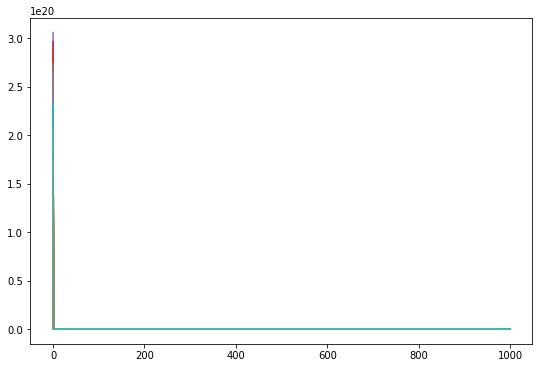

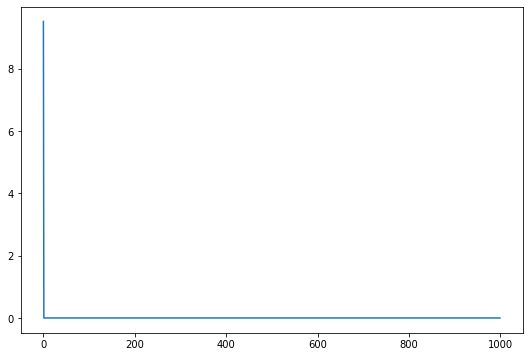

Epoch 2, 10% 	 train_loss: 0.13717 took: 3.02s
Epoch 2, 21% 	 train_loss: 0.14158 took: 2.97s
Epoch 2, 32% 	 train_loss: 0.13505 took: 2.95s
Epoch 2, 43% 	 train_loss: 0.13618 took: 2.96s
Epoch 2, 54% 	 train_loss: 0.13841 took: 2.95s
Epoch 2, 65% 	 train_loss: 0.13577 took: 2.91s
Epoch 2, 76% 	 train_loss: 0.12873 took: 2.90s
Epoch 2, 87% 	 train_loss: 0.12693 took: 2.87s
Epoch 2, 98% 	 train_loss: 0.12837 took: 2.90s


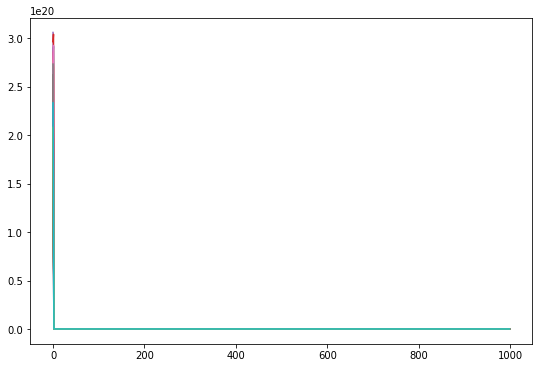

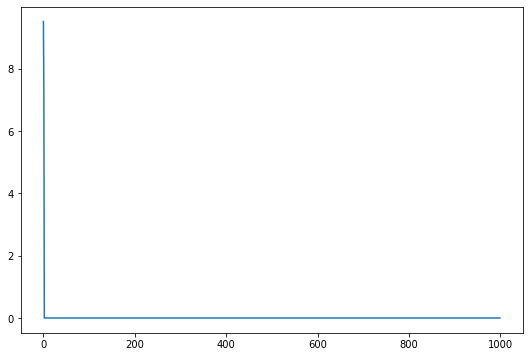

Epoch 3, 10% 	 train_loss: 0.12948 took: 3.00s
Epoch 3, 21% 	 train_loss: 0.12861 took: 2.86s
Epoch 3, 32% 	 train_loss: 0.12482 took: 2.89s
Epoch 3, 43% 	 train_loss: 0.12788 took: 2.92s
Epoch 3, 54% 	 train_loss: 0.12606 took: 2.87s
Epoch 3, 65% 	 train_loss: 0.12403 took: 2.93s
Epoch 3, 76% 	 train_loss: 0.12620 took: 2.94s
Epoch 3, 87% 	 train_loss: 0.12624 took: 2.92s
Epoch 3, 98% 	 train_loss: 0.12643 took: 2.90s


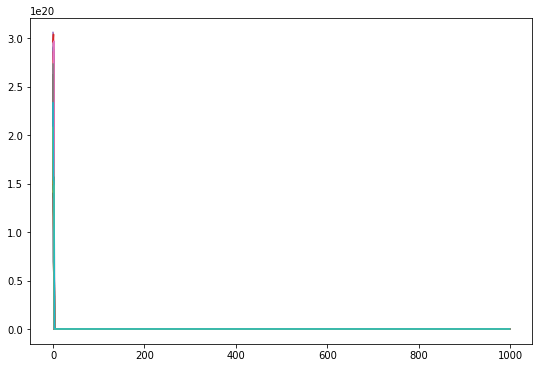

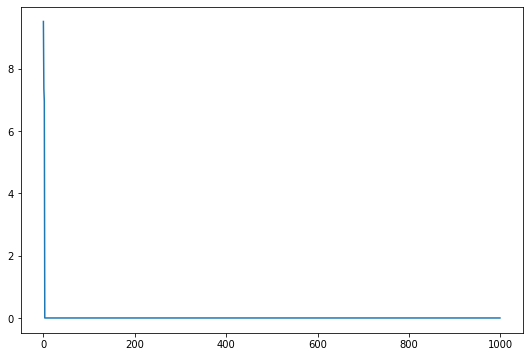

Epoch 4, 10% 	 train_loss: 0.12410 took: 2.99s
Epoch 4, 21% 	 train_loss: 0.12402 took: 2.92s
Epoch 4, 32% 	 train_loss: 0.11525 took: 2.91s
Epoch 4, 43% 	 train_loss: 0.11640 took: 2.95s
Epoch 4, 54% 	 train_loss: 0.11511 took: 2.98s
Epoch 4, 65% 	 train_loss: 0.11678 took: 2.93s
Epoch 4, 76% 	 train_loss: 0.11717 took: 2.96s
Epoch 4, 87% 	 train_loss: 0.11269 took: 2.91s
Epoch 4, 98% 	 train_loss: 0.11207 took: 2.91s


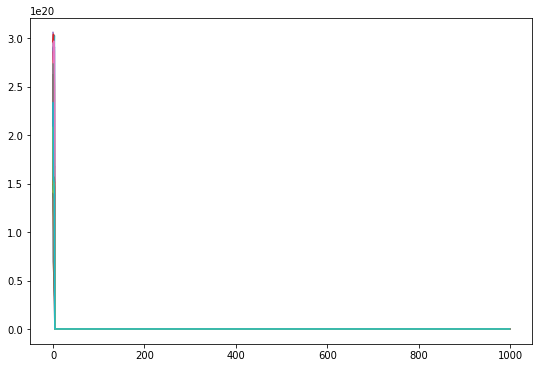

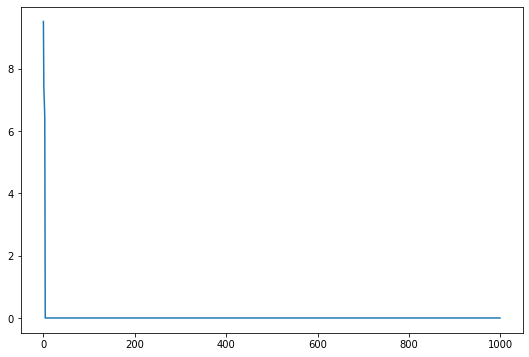

Epoch 5, 10% 	 train_loss: 0.11339 took: 2.98s
Epoch 5, 21% 	 train_loss: 0.11653 took: 3.00s
Epoch 5, 32% 	 train_loss: 0.11289 took: 3.01s
Epoch 5, 43% 	 train_loss: 0.11363 took: 2.98s
Epoch 5, 54% 	 train_loss: 0.11214 took: 3.02s
Epoch 5, 65% 	 train_loss: 0.11303 took: 2.98s
Epoch 5, 76% 	 train_loss: 0.11328 took: 3.05s
Epoch 5, 87% 	 train_loss: 0.11042 took: 3.21s


In [ ]:
def trainNet(net, batch_size, n_epochs, learning_rate):
    
    #Print all of the hyperparameters of the trning iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    #Get training data
    trn_loader = get_trn_loader(batch_size)
    val_loader = get_val_loader(batch_size)
    n_batches = len(trn_loader)
    
    #Create our loss and optimizer functions
    loss, optimizer = createLossAndOptimizer(net, learning_rate)
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    loss_progress=np.zeros((n_epochs,1))
    attribute_progress=np.zeros((n_epochs,N_OPS*N_PARAMS))

    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        total_train_loss = 0

        trn_delta=0
        
        for i, data in enumerate(trn_loader, 0):
            #Get inputs
            inputs, labels = data
            
            #Wrap them in a Variable object
            inputs, labels = inputs.cuda(),labels.cuda()
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(inputs)

            loss_size = loss(outputs, labels )

            if type(trn_delta)=="Int":
              trn_delta = torch.abs(trn_outputs- labels).cpu().detach().numpy()
            else:
              trn_delta =trn_delta+torch.abs(outputs- labels).cpu().detach().numpy()+trn_delta
              
          
            ## computes gradients
            loss_size.backward()

            ## performs update step
            optimizer.step()
            
            #Print statistics
            running_loss += loss_size.data.item()
            total_train_loss += loss_size.data.item()

            
            #Print every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                print("Epoch {}, {:d}% \t train_loss: {:.5f} took: {:.2f}s".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()

        per_attribute_delta_sum=np.sum(trn_delta,axis=0)

        attribute_progress[epoch,:]=per_attribute_delta_sum

        plt.plot(attribute_progress)
        fig_size = plt.gcf().get_size_inches() #Get current size
        sizefactor = 1.5 #Set a zoom factor
        # Modify the current size by the factor
        plt.gcf().set_size_inches(sizefactor * fig_size) 
        plt.show()



        loss_progress[epoch,:]=total_train_loss

        plt.plot(loss_progress)
        fig_size = plt.gcf().get_size_inches() #Get current size
        sizefactor = 1.5 #Set a zoom factor
        # Modify the current size by the factor
        plt.gcf().set_size_inches(sizefactor * fig_size) 
        plt.show()
    

        #print([val_outputs[0],labels[0]])
          
        try:
          play_audio(fm.generate(outputs[0].cpu().detach().numpy()),SAMPLE_RATE)
        except:
          print("failed producing clip")
            

        time.sleep(2)
        
        play_audio(fm.generate(labels[0].cpu().detach().numpy()),SAMPLE_RATE)

        ipd.set_matplotlib_close(close=True)
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

def createLossAndOptimizer(net, learning_rate):
    #Loss function
    loss = torch.nn.MSELoss()
    #Optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return(loss, optimizer)



trainNet(net, batch_size=32, n_epochs=1000, learning_rate=0.0001)